In [1]:
import os 
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [2]:
parameters_path = 'parameters.pickle'
param_path = 'params_1000.pickle'

In [3]:
import numpy as np 
import jax 
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import pickle

from cmspinn.spinn_jax import SPINN3d

In [4]:
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1).astype(np.float32)

In [5]:
with open(parameters_path, "rb") as f:
    parameters = pickle.load(f)

feat_sizes = parameters['feat_sizes']
r = parameters['r']
out_dim = parameters['out_dim']
Nx = parameters['Nx']
Ny = parameters['Ny']
Nz = parameters['Nz']
b_norm = parameters['b_norm']
pos_enc = parameters['pos_enc']
mlp = parameters['mlp']

subkey = jax.random.PRNGKey(0)
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
            )
apply_fn = jax.jit(model.apply)

with open(param_path, 'rb') as f:
    params = pickle.load(f)

x = jnp.linspace(0, 2, Nx).reshape(-1, 1)
y = jnp.linspace(0, 2, Ny).reshape(-1, 1)
z = jnp.linspace(0, 2, Nz).reshape(-1, 1)
x, y, z = jax.lax.stop_gradient(x), jax.lax.stop_gradient(y), jax.lax.stop_gradient(z)

Bx, By, Bz = apply_fn(params, x, y, z)
b = jnp.stack([Bx, By, Bz], axis=-1)*b_norm

2023-10-10 23:39:09.808332: W external/xla/xla/service/gpu/nvptx_compiler.cc:703] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
b.shape

(513, 257, 257, 3)

In [7]:
b = np.array(b)
b.shape

(513, 257, 257, 3)

In [8]:
import netCDF4

In [9]:
def load_nc_only_b(nc_file):
    nc=netCDF4.Dataset(nc_file, 'r')
    
    nc_bx=nc.variables['Bx']
    bx=nc_bx[:].transpose(2,1,0)
    nc_by=nc.variables['By']
    by=nc_by[:].transpose(2,1,0)
    nc_bz=nc.variables['Bz']
    bz=nc_bz[:].transpose(2,1,0)

    b = np.stack([bx, by, bz], -1)
    b = np.array(b)
    return b

In [10]:
B = load_nc_only_b("/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170906_083600.nc")

In [11]:
import numpy as np

def vector_norm(vector):
    return np.linalg.norm(vector, axis=-1)

def dot_product(a, b):
    return (a*b).sum(-1)


def metric(b, B):
    # b : model solution
    # B : reference magnetic field
    eps = 1e-7

    result = {}

    result['c_vec'] = np.sum(dot_product(B, b)) / np.sqrt(np.sum(vector_norm(B)**2) * np.sum(vector_norm(b)**2))
    
    M = np.prod(B.shape[:-1])
    nu = dot_product(B, b)
    de = vector_norm(B) * vector_norm(b)
    result['c_cs'] = (1 / M) * np.sum(np.divide(nu, de, where=de!=0.))

    E_n = np.sum(vector_norm(b - B)) / np.sum(vector_norm(B))
    result["E_n'"] = 1 - E_n
    
    nu = vector_norm(b - B)
    de = vector_norm(B)
    E_m = (1 / M) * np.sum(np.divide(nu, de, where=de!=0.))
    result["E_m'"] = 1 - E_m

    result['eps'] = np.sum(vector_norm(b)**2) / np.sum(vector_norm(B)**2)

    return result

import matplotlib.pyplot as plt 

def plot_overview(b, B, z=0, b_norm=2500):
    fig, axs = plt.subplots(2, 3, figsize=(12, 4))

    ax = axs[0]
    ax[0].imshow(b[..., z, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[0].set_title('bx')
    ax[1].imshow(b[..., z, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[1].set_title('by')
    ax[2].imshow(b[..., z, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[2].set_title('bz')

    ax = axs[1]
    ax[0].imshow(B[..., z, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[0].set_title('Bx')
    ax[1].imshow(B[..., z, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[1].set_title('By')
    ax[2].imshow(B[..., z, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[2].set_title('Bz')

    plt.tight_layout()
    plt.show()

def plot_s(mag, title, n_samples):
    fig, axs = plt.subplots(3, n_samples, figsize=(n_samples * 4, 12))
    heights = np.linspace(0, 1, n_samples) ** 2 * (mag.shape[2] - 1)  # more samples from lower heights
    heights = heights.astype(np.int32)
    for i in range(3):
        for j, h in enumerate(heights):
            v_min_max = np.max(np.abs(mag[:, :, h, i]))
            axs[i, j].imshow(mag[:, :, h, i].transpose(), cmap='gray', vmin=-v_min_max, vmax=v_min_max,
                            origin='lower')
            axs[i, j].set_axis_off()
    for j, h in enumerate(heights):
        axs[0, j].set_title('%.01f' % h)
    fig.tight_layout()
    fig.suptitle(title, fontsize=25)
    plt.show()

def plot_sample(b, B, n_samples=10):
    plot_s(b, 'b', n_samples)
    plot_s(B, 'B', n_samples)

In [12]:
result = metric(b, B)

In [13]:
print(result)

{'c_vec': 0.04658261131176861, 'c_cs': 0.020450047363821063, "E_n'": -1.0782226563571378, "E_m'": -12.065508181533074, 'eps': 0.27537802734728845}


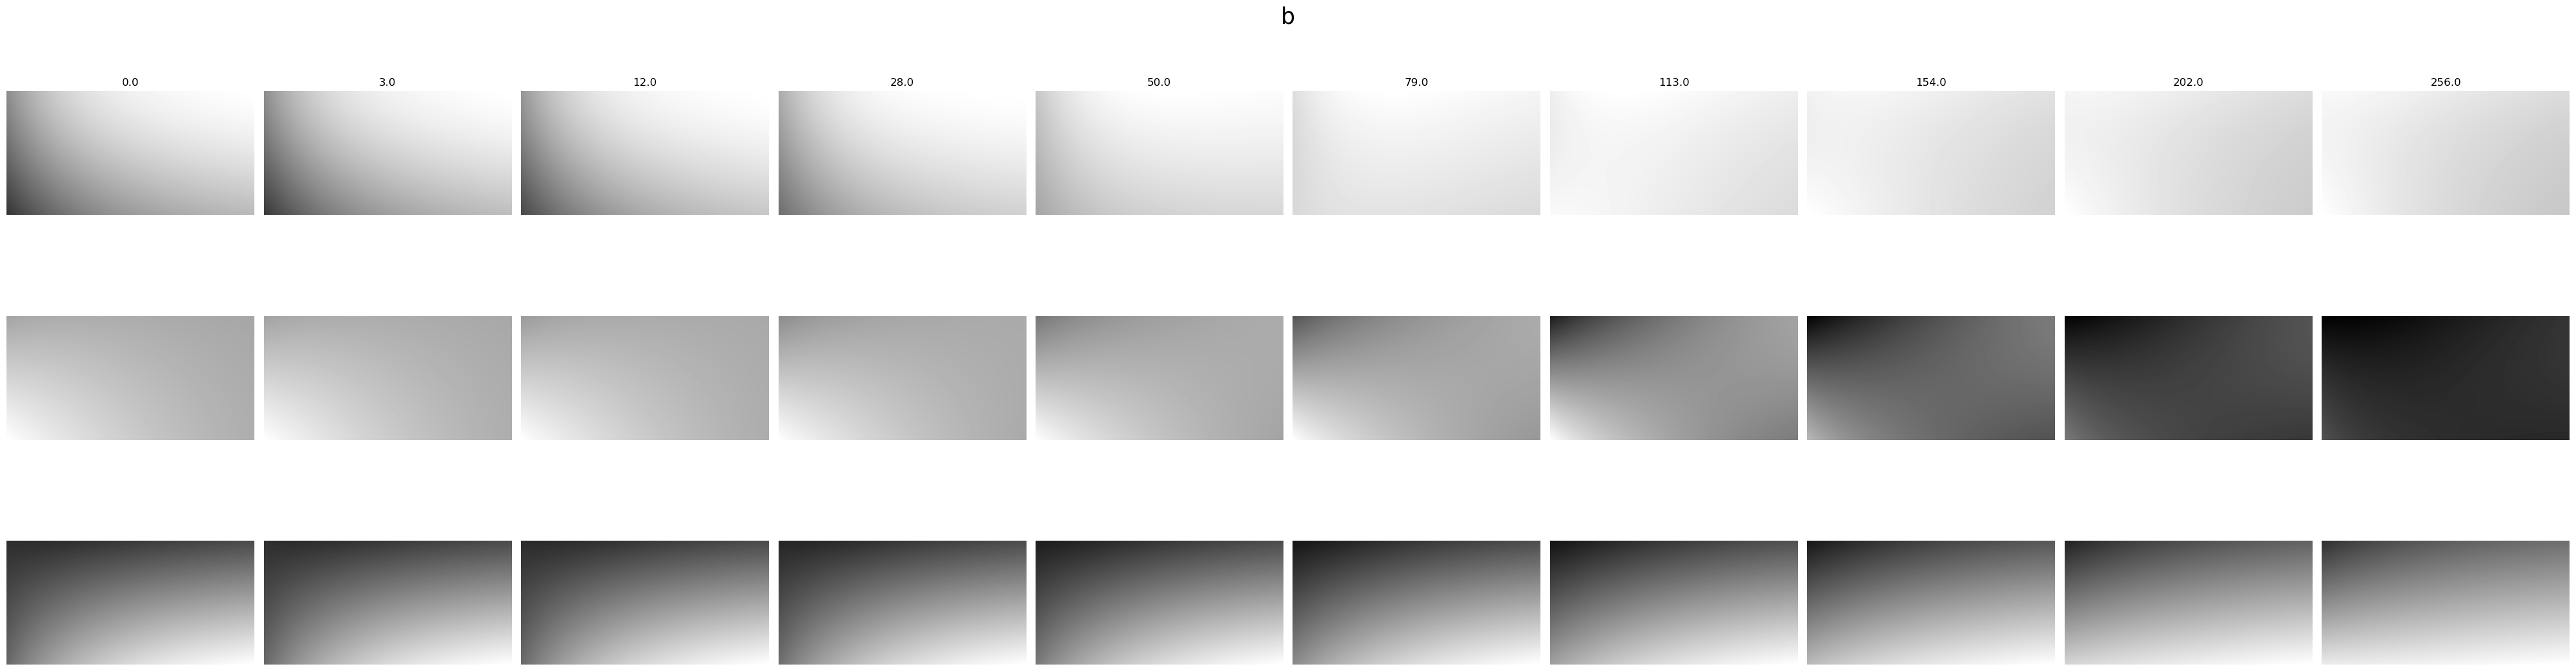

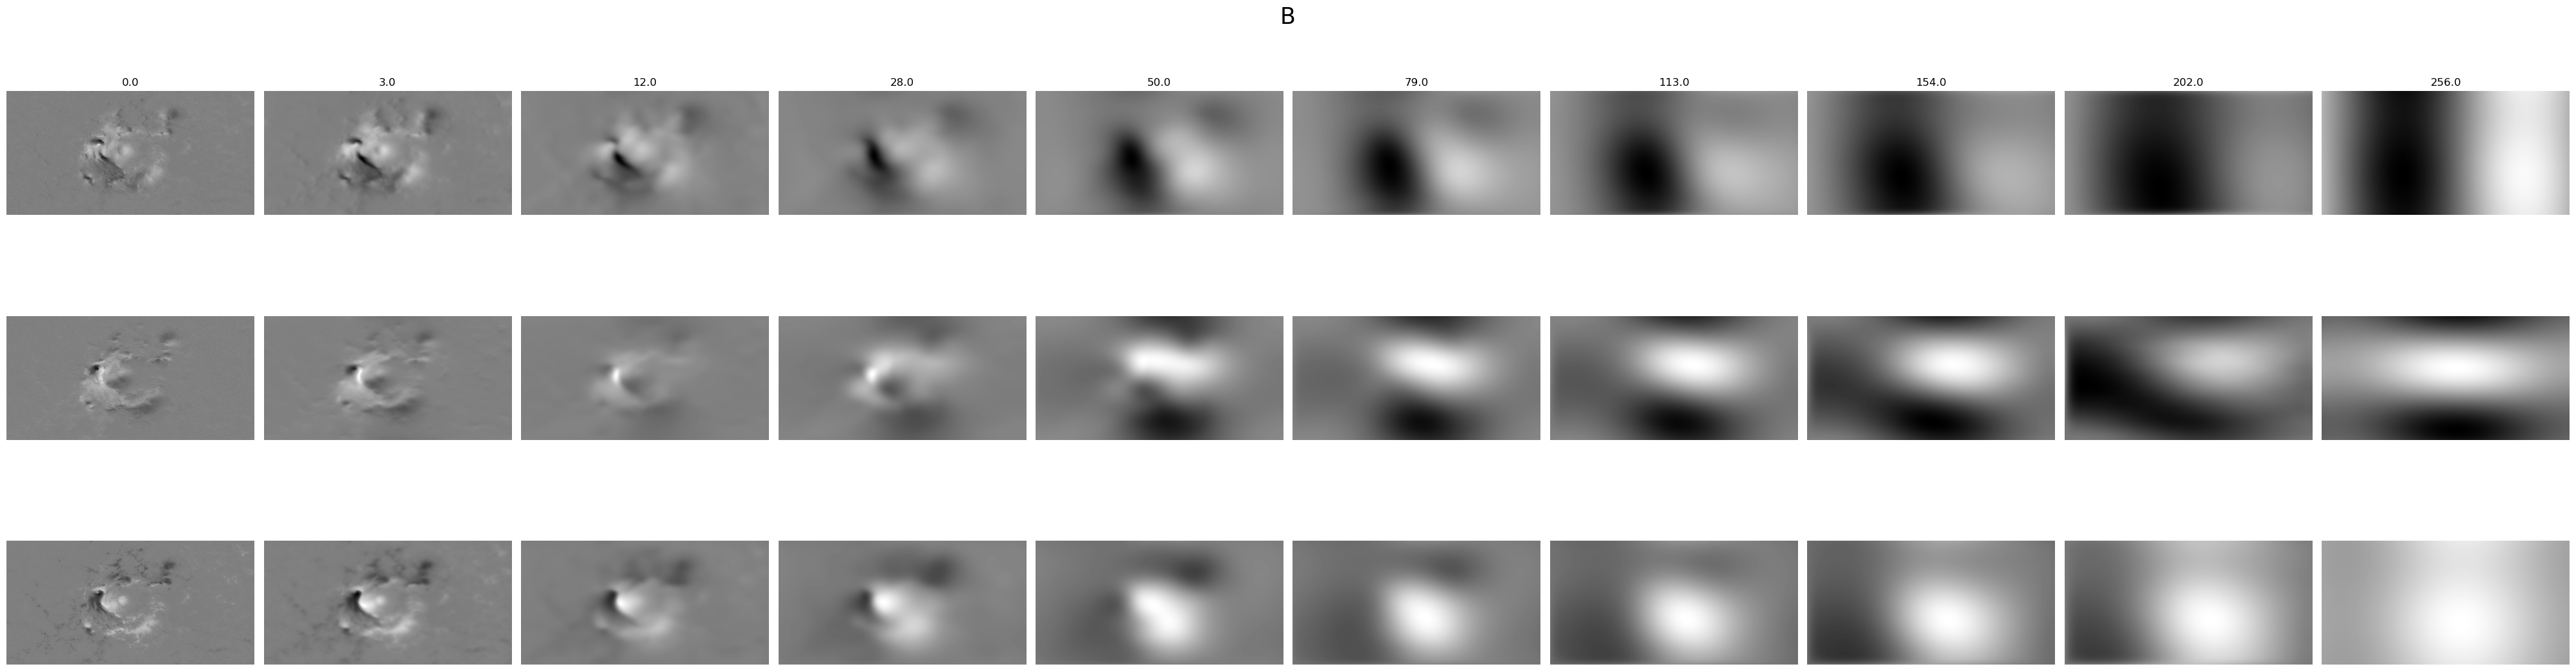

In [14]:
plot_sample(b, B, n_samples=10)

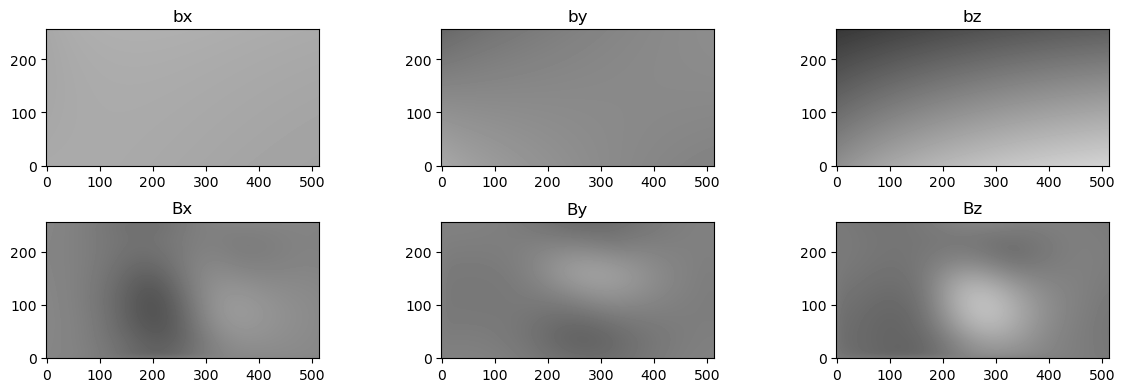

In [15]:
plot_overview(b, B, z=100, b_norm=100)